# Answering Business Questions with SQL 
<img src='https://www.businessbacker.com/wp-content/uploads/2015/03/questionmark_blog_post_904x400.jpg' />

As Business Analysts, we have been contacted by a fictional online music store called Chinook. The company wants our help with answering some business questions.

They provided access to their [database](https://github.com/lerocha/chinook-database), which contains information about the artists, songs, and albums from the music store. Employee information, customer information, and the details of purchase transactions can also be found in the database. The entity relationship diagram below provides a structural overview of the Chinook database:

<img src='https://s3.amazonaws.com/dq-content/189/chinook-schema.svg'
     height= '500'
     width='500'/>
     
## Importing Libraries
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sqlalchemy import create_engine

%matplotlib inline

## Connecting to the Database
---

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [3]:
# The engine helps us use the pandas read_sql function
engine = create_engine('sqlite:///chinook.db')

In [4]:
%%sql
-- Preview the tables in the database
SELECT COUNT(*) OVER(ORDER BY name) AS SN,
       name, 
       type
  FROM sqlite_master
 WHERE type IN ('table', 'view');

 * sqlite:///chinook.db
Done.


SN,name,type
1,album,table
2,artist,table
3,customer,table
4,employee,table
5,genre,table
6,invoice,table
7,invoice_line,table
8,media_type,table
9,playlist,table
10,playlist_track,table


>- The Chinook database contains 11 tables with information about the store's tracks, employees, customers, and purchase transactions.

## Selecting Albums to Purchase
---

### The Situation
The Chinook record store has just signed a deal with a new record label. They want us to advise on the first three albums they should add to the store from a list of four options. All four albums are by artists with no tracks in their store right now. Here are the names of the artists and the genre of music they produce:


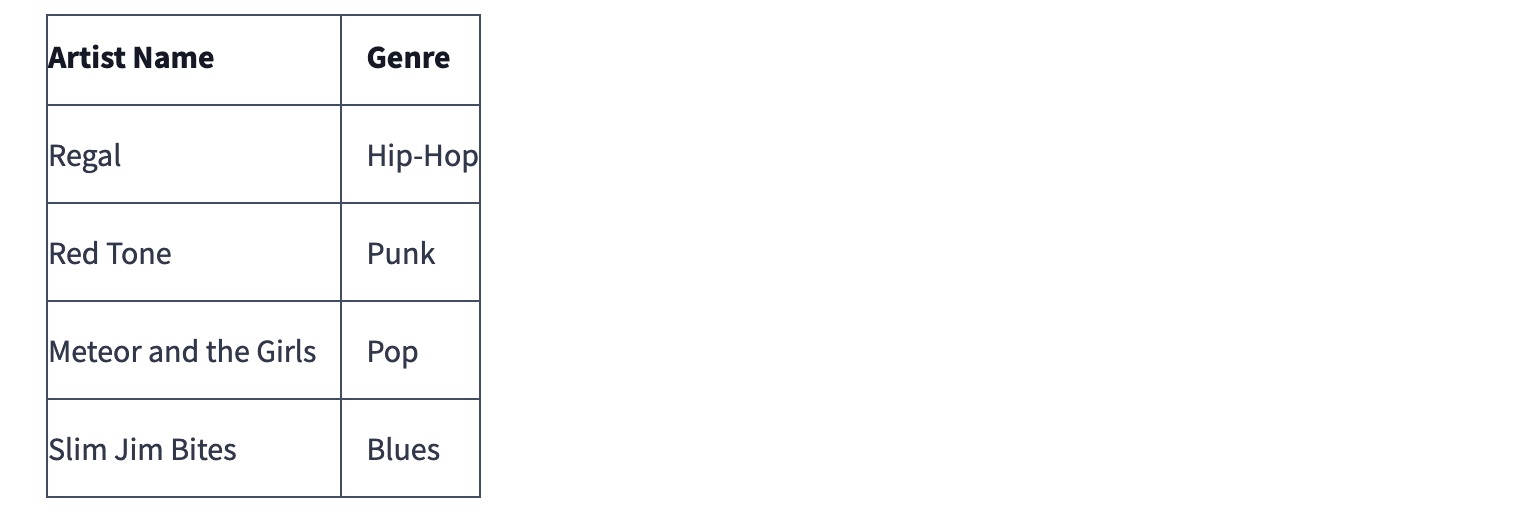

The record label specializes in artists from the USA. Hence, advertisements will target US-based customers. We are interested in finding out which genres sell the best in the USA.

### Analysis
We can write a query that returns each genre with the proportion of tracks sold in the USA:

In [5]:
query = """
        -- Collect relevant data from the invoice, genre and track tables
        WITH t1 AS (SELECT iv.billing_country,
                           il.quantity, 
                           gr.name as genre_name
                      FROM invoice iv
                      JOIN invoice_line il
                        ON iv.invoice_id = il.invoice_id
                      JOIN track tr
                        ON tr.track_id = il.track_id
                      JOIN genre gr
                        ON gr.genre_id = tr.genre_id
                     WHERE iv.billing_country = 'USA'
                   ),

        -- Compute the number of purchases per genre
              t2 AS (SELECT genre_name,
                            COUNT(*) AS num_purchases
                       FROM t1
                      GROUP BY 1
                      ORDER BY 2 DESC
                    ) 

        -- Compute the percentage of purchases per genre
        SELECT *, 
                ROUND(num_purchases * 100 / 
                      CAST(
                           (SELECT SUM(num_purchases) FROM t2) 
                            AS Float
                          ), 1
                     ) AS percentage_sold
          FROM t2;
        """

df = pd.read_sql(query, engine)
df

,genre_name,num_purchases,percentage_sold
0,Rock,561,53.4
1,Alternative & Punk,130,12.4
2,Metal,124,11.8
3,R&B/Soul,53,5.0
4,Blues,36,3.4
5,Alternative,35,3.3
6,Pop,22,2.1
7,Latin,22,2.1
8,Hip Hop/Rap,20,1.9
9,Jazz,14,1.3


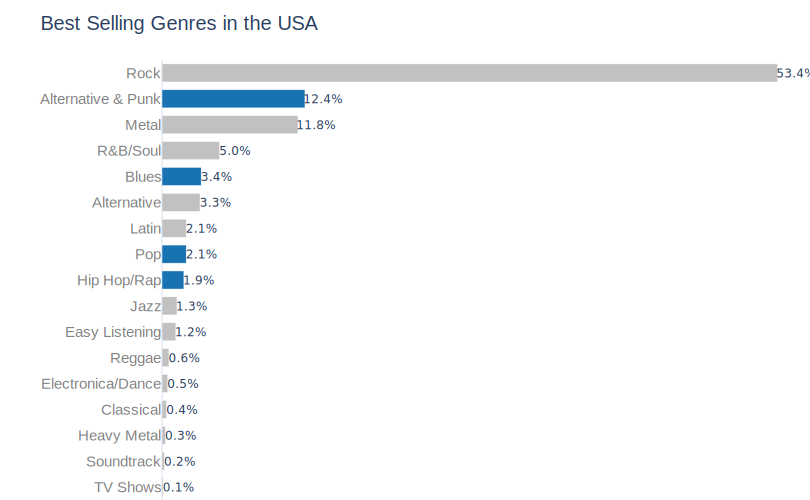

In [6]:
df = df.sort_values(by='percentage_sold')
fig = px.bar(df, y='genre_name', x='percentage_sold',  width= 810, height=500, orientation='h')

# Create a color map to identify key albums of interest
album_options = ['Hip Hop/Rap', 'Alternative & Punk', 'Blues', 'Pop']
cmap = df['genre_name'].apply(lambda x: x in album_options)

fig.update_traces(text = [f'{val}\u0025' for val in df['percentage_sold']],
                  width=0.7, 
                  textposition='outside', 
                  textfont=dict(family='trebuchet MS',size=12),
                  marker=dict(color=cmap.astype(int), colorscale=[[0, '#BABABA'], [1, '#0064AB']],
                             opacity=0.9)
                 )

fig.update_xaxes(showgrid=False, showticklabels=False)
fig.update_yaxes(tickfont_color='grey', ticksuffix='   ', tickfont=dict(size=15))

fig.update_layout(template='plotly_white', 
                  font_family='Arial',
                  xaxis_title=None, 
                  yaxis_title='',
                  title='Best Selling Genres in the USA<br>'+
                  '<sup>Percentage of total sales by genre. Current options are highlighted in blue</sup>',
                  titlefont_size=20,
                  margin=dict(b=0, r=0))
fig.show('svg')

### The Solution
> Based on the sales of tracks across different genres in the USA, Chinook should add the following albums to their store:
>- Red Tone (Punk)
>- Slim Jim Bites (Blues)
>- Meteor and the Girls (Pop)
>
> It's worth noting that these three genres only make up **17%** of total sales. To maximize profitability, the company should be on the lookout for Rock songs since they account for **53%** of sales in the US market.